# Import packages

In [1]:
import os
import random
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.cluster import KMeans

import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import Sequential, Model
from tensorflow.keras import regularizers, layers

from collections import defaultdict
from tqdm import tqdm

import keras_cv

2024-05-04 11:35:35.322243: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 11:35:35.322362: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 11:35:35.449125: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using TensorFlow backend


# Setup datasets

In [2]:
IMG_SIZE = 224
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE = 32

In [3]:
metadata_df = pd.read_csv('/kaggle/input/skin-cancer-dataset/HAM10000_metadata.csv')
metadata_df.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [4]:
dataset_name = "skin-cancer-7-classes"
dataset_image_path = '/kaggle/input/skin-cancer-dataset/Skin Cancer/Skin Cancer/'

In [5]:
all_classes = metadata_df.dx.unique()
all_classes

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [6]:
classes_dict = {
    'bkl': "benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses)", 
    'nv': "melanocytic nevi",
    'df': "dermatofibroma", 
    'mel': "melanoma", 
    'vasc': "vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage)", 
    'bcc': "basal cell carcinoma", 
    'akiec': "Actinic keratoses and intraepithelial carcinoma / Bowen's disease"
}

classes_group_dict = {
    'dangerous': ['mel', 'akiec'],
    'non-dangerous': ['bkl', 'nv', 'df', 'vasc', 'bcc']
}

classes = [
    'bkl', 
    'nv', 
    'df', 
    'mel', 
    'vasc', 
    'bcc', 
    'akiec'
]
num_classes = len(classes)
num_classes, classes

(7, ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'])

In [7]:
error_count = 0

data_dict = defaultdict(list)
count_dict = defaultdict(int)
root_images = []
root_labels = []

limit = 500

for i in tqdm(metadata_df.index):
    row = metadata_df.loc[i, ["image_id", "dx"]]
    label = row.dx
    if label not in classes: continue
    if count_dict[label] >= limit: continue
        
    try:
        image_id = row.image_id
        path = os.path.join(dataset_image_path, image_id + '.jpg')
        
        image = cv2.imread(path)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        count_dict[label] += 1
        data_dict[label].append(image)
        root_images.append(image)
        root_labels.append(label)
    except:
        error_count += 1
        
print("ErrorCount:", error_count)
print("Total Images:", len(root_images))

100%|██████████| 10015/10015 [01:05<00:00, 153.48it/s]

ErrorCount: 0
Total Images: 2584


bkl      500
nv       500
mel      500
bcc      500
akiec    327
vasc     142
df       115
Name: count, dtype: int64


Text(0.5, 0, '')

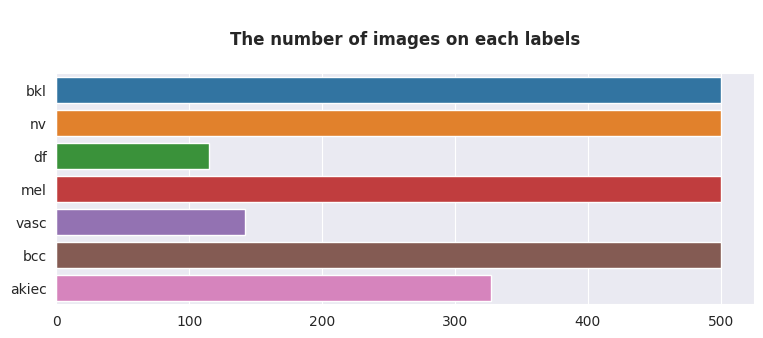

In [8]:
print(pd.Series(root_labels).value_counts())
plt.figure(figsize=(9, 3))
sns.countplot(y=pd.Series(root_labels))
plt.title("\nThe number of images on each labels\n", weight="bold")
plt.xlabel("")

# Visualize origin data

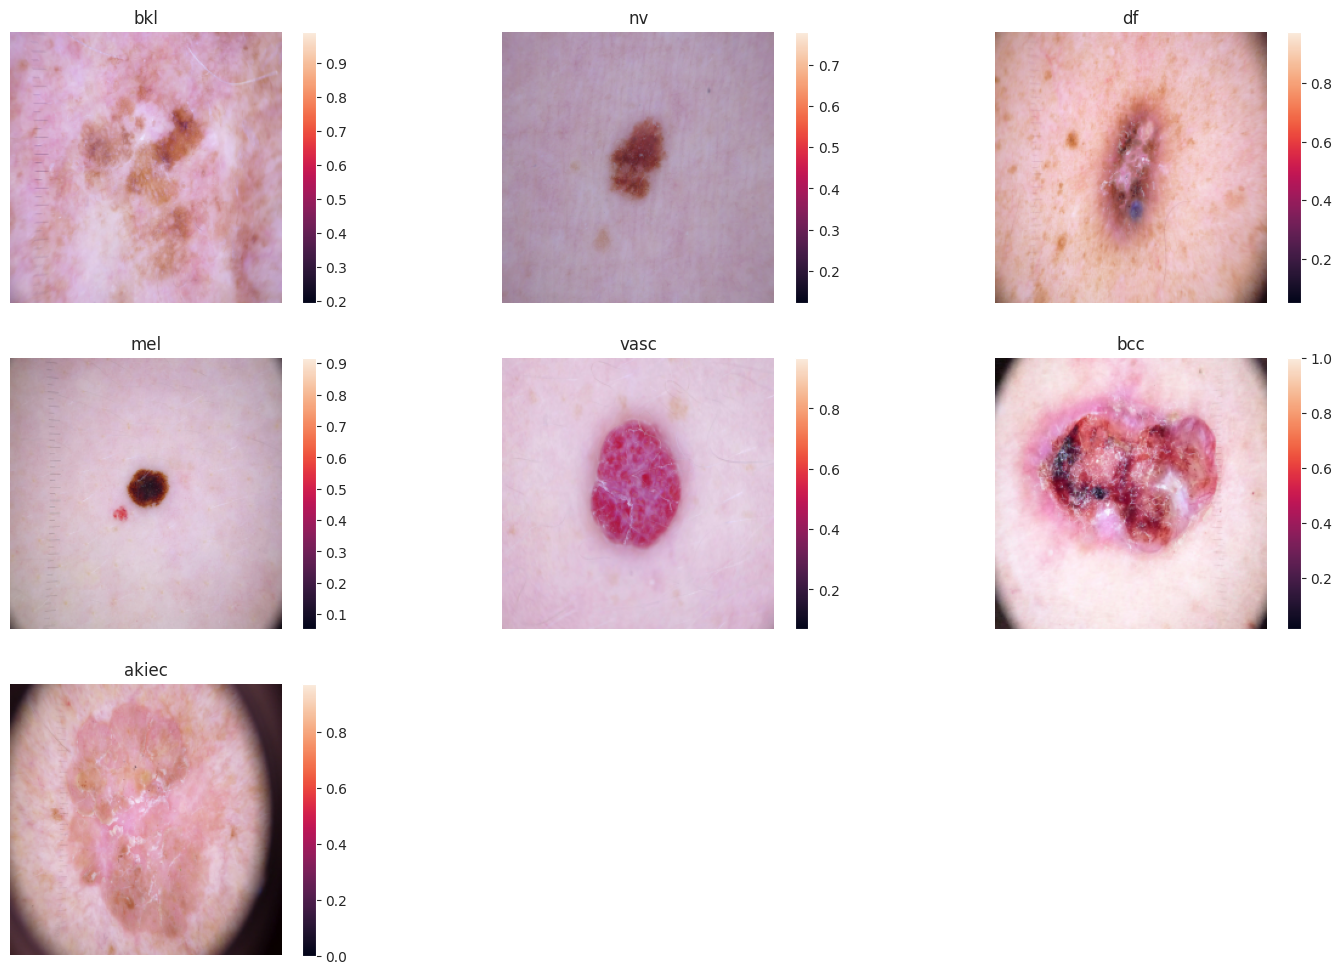

In [9]:
def visualize_datasets(images, labels, k=4, cols=4, seed=42):

    if k > len(images): k = len(images)
    rows = int(np.ceil(k / cols))
    fig = plt.figure(figsize=(6 * cols, 4 * rows))

    for i in range(k):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.title.set_text(labels[i])
        plt.imshow(images[i] / 255.0)
        plt.colorbar()
        plt.axis('off')

    plt.show()

sample_images = [data_dict[i][0] for i in data_dict.keys()]
sample_labels = list(data_dict.keys())
visualize_datasets(sample_images, sample_labels, k=len(data_dict), cols=3)

# Kmean Clustering for Segmentation

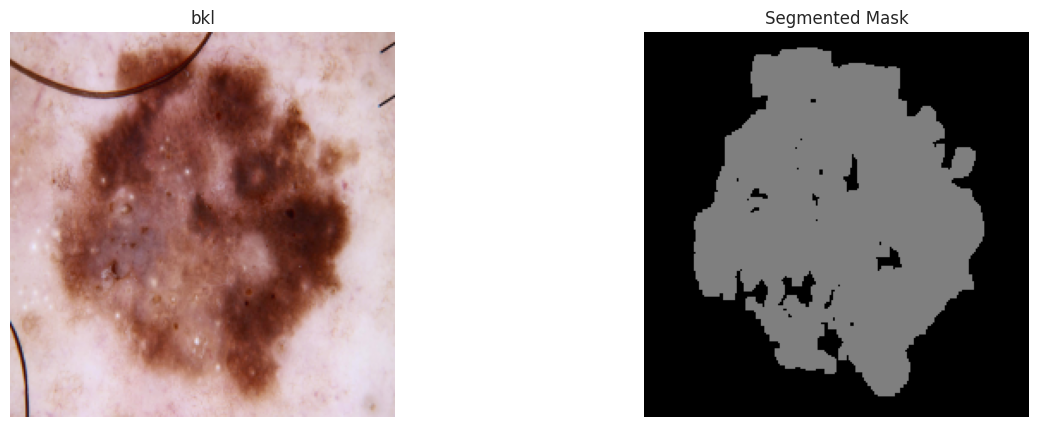

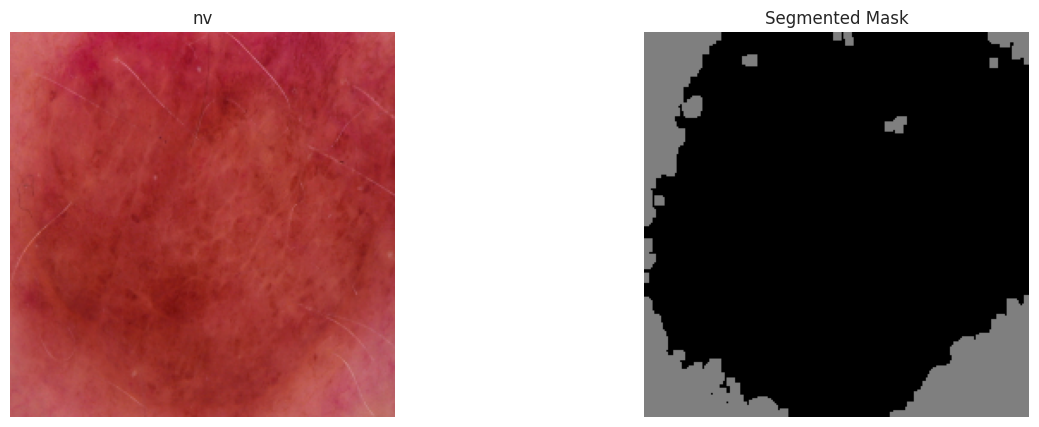

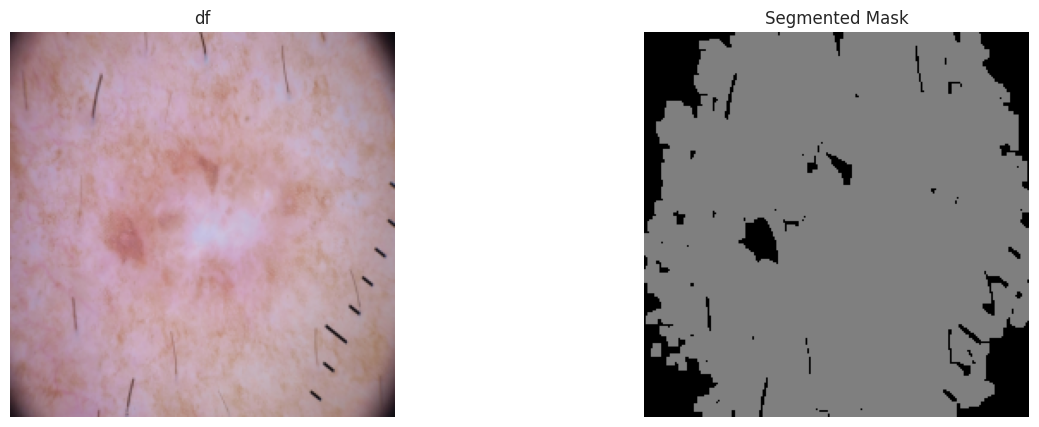

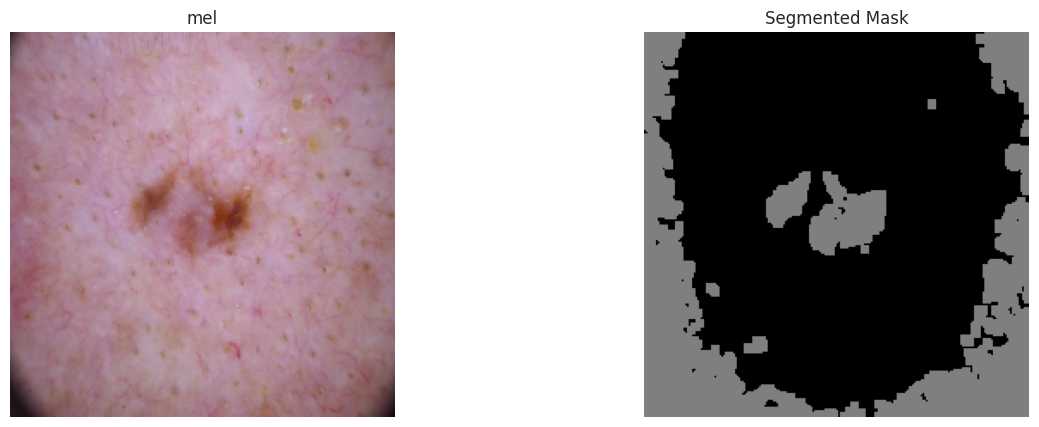

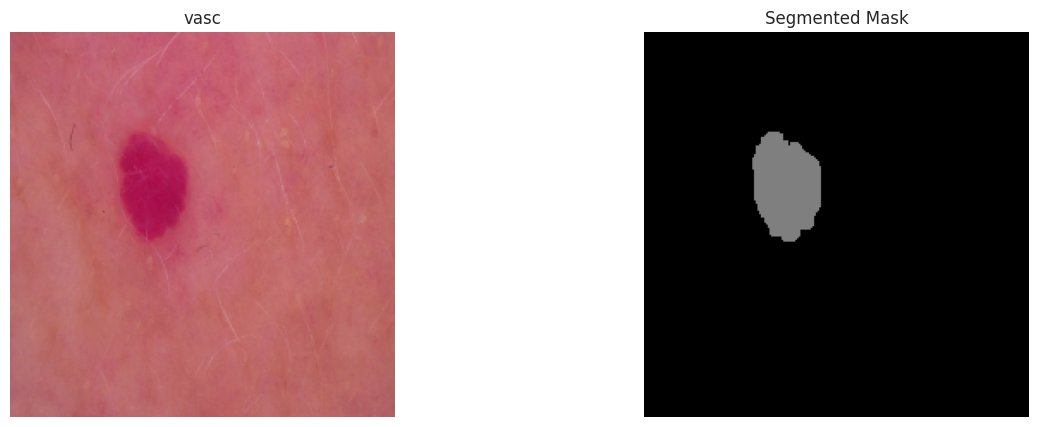

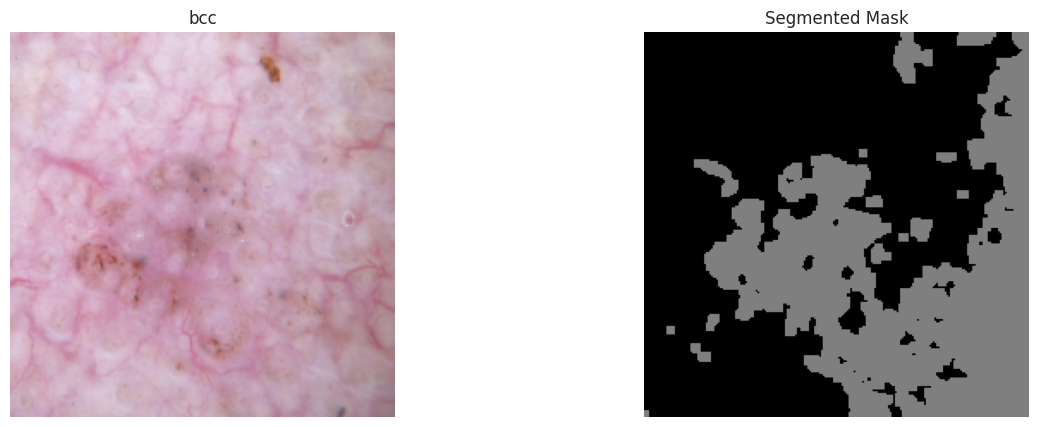

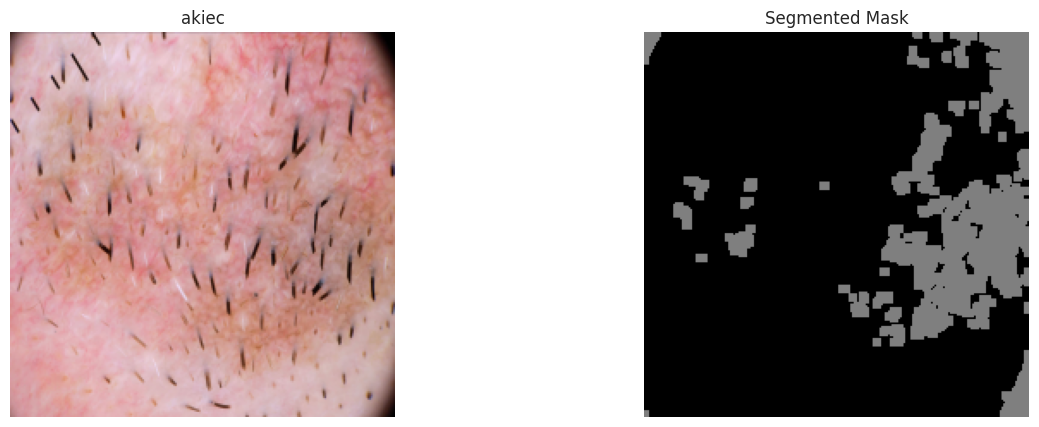

In [10]:
n_clusters=2

random.seed(42)
batch = [random.choices(data_dict[lab], k=1)[0] for lab in data_dict]

for i, img in enumerate(batch):
    
    w, h, channel = img.shape
    X = np.reshape(img, (w * h, channel))
    
    # Kmeans clustering with 3 clusters
    kmeans = KMeans(n_clusters, random_state=0, n_init='auto').fit(X)

    pred_label = kmeans.predict(X)
    pred_label = np.reshape(pred_label, (h, w))

    mask = np.zeros(shape=(h, w, channel))
    mask_colors = [
        (0.0, 0.0, 0.0),
        (0.5, 0.5, 0.5),
        (1.0, 1.0, 1.0),
    ]

    # Display image clustering
    fg, ax = plt.subplots(1, 2, figsize = (15, 5))
    
    ax[0].imshow(img / 255.0)
    ax[0].set_title(f"{classes[i]}")
    ax[0].axis('off')
    
    for i in range(n_clusters):
        mask[pred_label == i] = mask_colors[i % len(mask_colors)]
        
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=2) 
    ax[1].imshow(mask)
    ax[1].set_title(f'Segmented Mask')
    ax[1].axis('off')

# MixUp 

# Encode datasets

In [11]:
x_arr = np.array(root_images)
y_arr = tf.one_hot([classes.index(label) for label in root_labels], num_classes).numpy()
x_arr.shape, y_arr.shape

((2584, 224, 224, 3), (2584, 7))

In [12]:
x_tensor = tf.constant(x_arr, tf.float32)
y_tensor = tf.one_hot([classes.index(label) for label in root_labels], num_classes)
x_tensor.shape, y_tensor.shape

(TensorShape([2584, 224, 224, 3]), TensorShape([2584, 7]))

In [13]:
image_per_class = 1000
mix_per_batch = 42
mixup = keras_cv.layers.Augmenter([
    keras_cv.layers.MixUp(),
])
root_label_df = pd.DataFrame({"dx": root_labels})

x_tensor_mix = None
y_tensor_mix = None

for label, count in count_dict.items():
    
    num_mix_least = image_per_class - count
    num_batch = num_mix_least // mix_per_batch
    num_mix = num_batch * mix_per_batch
    print(f"Found {count} image(s) belong to {label}. Generating {num_mix} ({num_batch} batch(s)) by mixup...")
    
    for i in range(num_batch):
        indices = np.random.choice(count, mix_per_batch, replace=False)
        real_index = root_label_df[root_label_df.dx == label].index[indices]
        
        x_mix = tf.gather(x_tensor, real_index)
        y_mix = tf.gather(y_tensor, real_index)
        
        mix_out = mixup({"images": x_mix, "labels": y_mix})
        
        if x_tensor_mix is None:
            x_tensor_mix = mix_out["images"]
            y_tensor_mix = mix_out["labels"]
        else:
            x_tensor_mix = tf.concat([x_tensor_mix, mix_out["images"]], axis=0)
            y_tensor_mix = tf.concat([y_tensor_mix, mix_out["labels"]], axis=0)
        
    
    print(f"Mixup complete. {label}: {count + num_mix} image(s).")

Found 500 image(s) belong to bkl. Generating 462 (11 batch(s)) by mixup...
Mixup complete. bkl: 962 image(s).
Found 500 image(s) belong to nv. Generating 462 (11 batch(s)) by mixup...
Mixup complete. nv: 962 image(s).
Found 115 image(s) belong to df. Generating 882 (21 batch(s)) by mixup...
Mixup complete. df: 997 image(s).
Found 500 image(s) belong to mel. Generating 462 (11 batch(s)) by mixup...
Mixup complete. mel: 962 image(s).
Found 142 image(s) belong to vasc. Generating 840 (20 batch(s)) by mixup...
Mixup complete. vasc: 982 image(s).
Found 500 image(s) belong to bcc. Generating 462 (11 batch(s)) by mixup...
Mixup complete. bcc: 962 image(s).
Found 327 image(s) belong to akiec. Generating 672 (16 batch(s)) by mixup...
Mixup complete. akiec: 999 image(s).


## Visualize MixUp

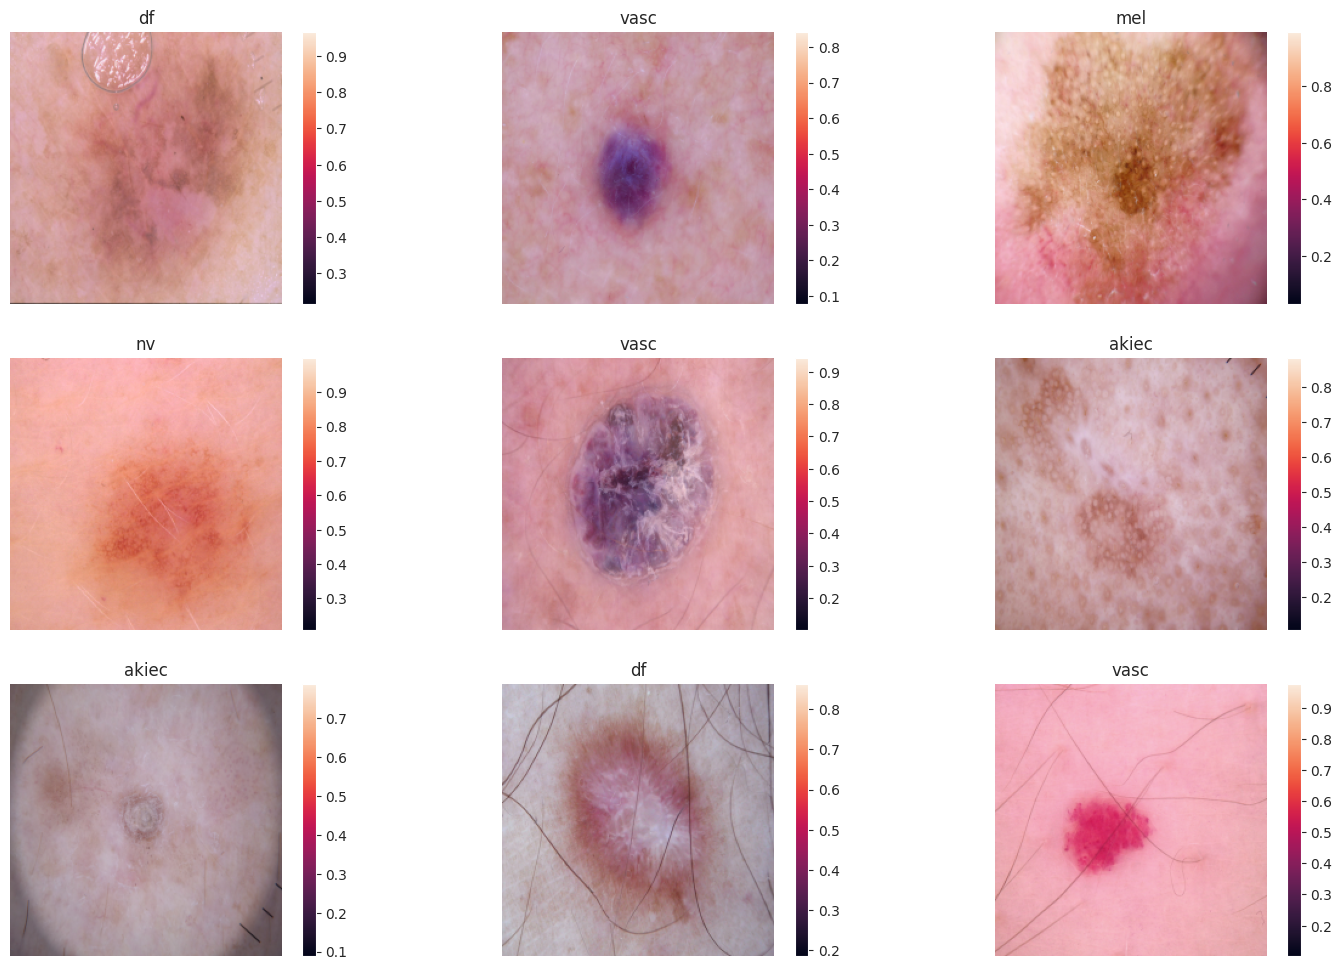

In [14]:
mix_length = x_tensor_mix.shape[0]
sample_indices = np.random.choice(mix_length, size=9)
sample_images = tf.gather(x_tensor_mix, sample_indices).numpy()
sample_labels = tf.gather(tf.argmax(y_tensor_mix, axis=-1), sample_indices).numpy()
sample_labels = [classes[i] for i in sample_labels]
visualize_datasets(sample_images, sample_labels, k=9, cols=3)

# Merge Mixup Data

In [15]:
x_merge_mix = np.concatenate((x_arr, x_tensor_mix.numpy()), axis=0)
y_merge_mix = np.concatenate((y_arr, y_tensor_mix.numpy()), axis=0)

x_merge_mix.shape, y_merge_mix.shape

((6826, 224, 224, 3), (6826, 7))

akiec    999
df       997
vasc     982
nv       962
bkl      962
mel      962
bcc      962
Name: count, dtype: int64


Text(0.5, 0, '')

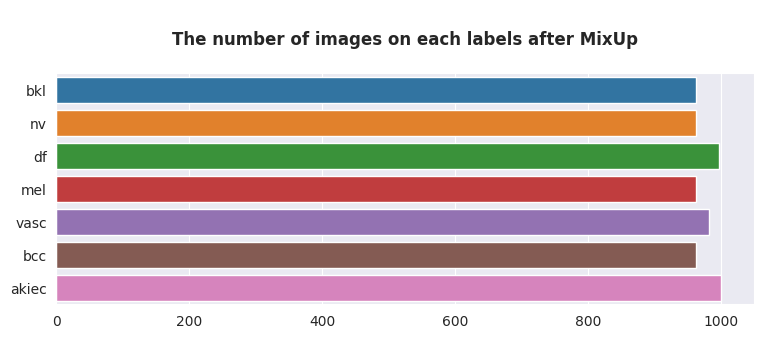

In [16]:
mixed_labels = [classes[i] for i in np.argmax(y_merge_mix, axis=1)]
print(pd.Series(mixed_labels).value_counts())
plt.figure(figsize=(9, 3))
sns.countplot(y=pd.Series(mixed_labels))
plt.title("\nThe number of images on each labels after MixUp\n", weight="bold")
plt.xlabel("")

# Split datasets

In [17]:
x = x_merge_mix
y = y_merge_mix

In [18]:
# Split the data into training and remaining sets (validation + test)
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
# Split the remaining data into validation and test sets
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

[
    x_train.shape, 
    x_val.shape, 
    x_test.shape, 
    y_train.shape , 
    y_val.shape,
    y_test.shape
]

[(5460, 224, 224, 3),
 (683, 224, 224, 3),
 (683, 224, 224, 3),
 (5460, 7),
 (683, 7),
 (683, 7)]

# Helper functions

In [19]:
def plot_acc(model_history, name):
    plt.rcParams.update({'font.size': 14})
    print('\n\n')
    epochs = len(model_history.history["accuracy"])
    plt.figure(figsize=(12,8))
    plt.plot(np.arange(0, epochs), model_history.history["accuracy"], label="train_acc", marker="o")
    plt.plot(np.arange(0, epochs), model_history.history["val_accuracy"], label="val_acc", marker="o")
    plt.title("Training Accuracy - {}".format(name))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [20]:
def plot_loss(model_history, name):
    plt.rcParams.update({'font.size': 14})
    print('\n\n')
    epochs = len(model_history.history["loss"])
    plt.figure(figsize=(12,8))
    plt.plot(np.arange(0, epochs), model_history.history["loss"], label="train_loss", marker="o")
    plt.plot(np.arange(0, epochs), model_history.history["val_loss"], label="val_loss", marker="o")
    plt.title("Training Loss - {}".format(name))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [21]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.rcParams.update({'font.size': 14})
    
    # plot the confusion matrix
    class_count = len(classes)
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
    plt.xticks(np.arange(class_count) + 0.5, classes, rotation=90)
    plt.yticks(np.arange(class_count) + 0.5, classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

In [22]:
def evaluate(model, x, y):
    scores = model.evaluate(x, y, verbose=1)
    return scores

In [23]:
def predict_prob(model):
    return model.predict(x_test, batch_size=BATCH_SIZE, verbose=1)

In [24]:
def predict(model):
    predictions = predict_prob(model)
    return np.argmax(predictions, axis=1)

In [25]:
def calculate_metrics(y_true, y_pred):
    
    # precision tp / (tp + fp)
    precision = precision_score(y_true, y_pred, average='weighted')
    print("Precision: {}".format(precision))

    # recall: tp / (tp + fn)
    recall = recall_score(y_true, y_pred, average='weighted')
    print("Recall:    {}".format(recall))

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_true, y_pred, average='weighted')
    print("F1:        {}".format(f1))

# Setup Training

In [26]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=15,
    restore_best_weights=True,
    verbose=1,
)

In [27]:
def transfer_learning(model, name, epochs=30):
    
    best_weights_ph1 = f"{dataset_name}_{name}_ph1_weights.keras"
    
    callbacks_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath = best_weights_ph1,
        monitor = "val_accuracy",
        mode = "max",
        save_weights_only=True,
        save_best_only = True,
        verbose=1, # Logging when callback running
    )
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=optimizer, 
        loss='categorical_crossentropy', 
        metrics=[
            'accuracy', 
        ]
    )
    
    print("Model summary for transfer learning: ")
    print("Total params: {:.2f}M".format(sum(layer.count_params() for layer in model.layers) / 1e6))
    print("Trainable params: {:.2f}M".format(sum(layer.count_params() if layer.trainable else 0 for layer in model.layers) / 1e6))
    print("Non-Trainable params: {:.2f}M".format(sum(layer.count_params() if not layer.trainable else 0 for layer in model.layers) / 1e6))
    
    history = model.fit(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
        validation_data=(x_val, y_val),
        validation_batch_size=BATCH_SIZE,
        epochs = epochs,
        callbacks = [callbacks_checkpoint, early_stop]
    )
    
    acc_max = max(history.history["accuracy"])
    acc_min = min(history.history["accuracy"])
    print("Training Acc:", [acc_min, acc_max])
    
    val_acc_max = max(history.history["val_accuracy"])
    val_acc_min = min(history.history["val_accuracy"])
    print("Validation Acc:", [val_acc_min, val_acc_max])
    
    best_idx = np.argmax(history.history["val_accuracy"])
    print('The best val_acc result expected at epoch {} with metrics: '.format(best_idx + 1))
    
    for k, vals in history.history.items():
        print('{}: {}'.format(k, vals[best_idx]))
    
    print('\nRestoring best weights and predicting validation set.')
    model.load_weights(best_weights_ph1)
    model.save(f"{dataset_name}_{name}_ph1_model.h5")
    
    loss, acc, *other_acc = evaluate(model, x_test, y_test)
    print('Transfer Learning test scores (loss, acc):', [loss, acc])
    plot_acc(history, f"\n Transfer Learning - ACC: {name} PhA.")
    plot_loss(history, f"\n Transfer Learning - LOSS: {name} PhA.")
    y_pred = predict(model)
    return history, model, val_acc_max, y_pred

# Setup fine tuning

In [28]:
def fine_turning(model, name, acc_ph1=0, epochs=60):
    
    best_weights_ph2 = f"{dataset_name}_{name}_ph2_weights.keras"
    callbacks_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath = best_weights_ph2, 
        monitor = "val_accuracy", 
        mode = "max",
        initial_value_threshold=acc_ph1,
        save_weights_only=True, 
        save_best_only = True, 
        verbose=1, # Logging when callback running
    )
    
    model.trainable = True
#     for layer in model.layers:
#         if not isinstance(layer, layers.BatchNormalization) and not isinstance(layer, layers.LayerNormalization):
#             layer.trainable = True
    
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, 
        loss='categorical_crossentropy', 
        metrics=[
            'accuracy', 
        ]
    )
    print("Model summary for fine tuning: ")
    print("Total params: {:.2f}M".format(sum(layer.count_params() for layer in model.layers) / 1e6))
    print("Trainable params: {:.2f}M".format(sum(layer.count_params() if layer.trainable else 0 for layer in model.layers) / 1e6))
    print("Non-Trainable params: {:.2f}M".format(sum(layer.count_params() if not layer.trainable else 0 for layer in model.layers) / 1e6))
    
    history = model.fit(
        x_train, 
        y_train,
        batch_size=BATCH_SIZE,
        validation_data=(x_val, y_val),
        validation_batch_size=BATCH_SIZE,
        epochs = epochs,
        callbacks = [callbacks_checkpoint, early_stop]
    )
    
    acc_max = max(history.history["accuracy"])
    acc_min = min(history.history["accuracy"])
    print("Training Acc:", [acc_min, acc_max])
    
    val_acc_max = max(history.history["val_accuracy"])
    val_acc_min = min(history.history["val_accuracy"])
    print("Validation Acc:", [val_acc_min, val_acc_max])
    
    best_idx = np.argmax(history.history["val_accuracy"])
    print('The best val_acc result expected at epoch {} with metrics: '.format(best_idx))
    for k, vals in history.history.items():
        print('{}: {}'.format(k, vals[best_idx]))
    
    print('Restoring best weights of Ph2 and predicting test set.')
    model.load_weights(best_weights_ph2)
    model.save(f"{dataset_name}_{name}_ph2_model.h5")
    
    loss, acc, *other_acc = evaluate(model, x_test, y_test)
    print('Fine Tuning test scores (loss, acc):', [loss, acc])
    
    if val_acc_max < acc_ph1:
        print('\nPhase 2 resulted in lower accuracy than Phase 1.')
    
    plot_acc(history, f"\n Fine Tuning - ACC: {name} PhB.")
    plot_loss(history, f"\n Fine Tuning - LOSS: {name} PhB.")
    
    y_pred = predict(model)
    return history, model, val_acc_max, y_pred

# Setup save history

In [29]:
def save_history(history, path):
    history_df = pd.DataFrame(data=history)
    history_df.index.name = "Epoch"
    history_df.to_csv(path)
    print("Saved history completed.")


# Build Model

# Define Model Holder

In [30]:
class ExpModel:
    
    priority = 0
    
    def __init__(self, model, name, pretrained=True, priority=None, is_ready=True):
        
        self.model = model
        self.name = name
        self.pretrained = pretrained
        self.priority = priority
        if self.priority is None:
            ExpModel.priority += 1
            self.priority = ExpModel.priority
        self.is_ready = is_ready

exp_models = dict()

# ResNet50

In [31]:
pretrained = tf.keras.applications.ResNet50(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False)
pretrained.trainable = False

def build_model():
    
    x_input = pretrained.input
    x = pretrained.output
    x = layers.GlobalAvgPool2D()(x)
    output = layers.Dense(num_classes, activation='softmax')(x)
    
    return tf.keras.Model(x_input, output, name='ResNet50')

model = build_model()
exp_models['ResNet50'] = ExpModel(model, 'ResNet50', is_ready=False)
print(f"{model.name}: {len(model.layers)} layers. {(sum(layer.count_params() for layer in model.layers) / 1e6):.2f}M params.")

94765736/94765736 [==============================] - 1s 0us/step
ResNet50: 177 layers. 23.60M params.


# DenseNet169

In [32]:
pretrained = tf.keras.applications.DenseNet169(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False)
pretrained.trainable = False

def build_model():
    
    x_input = pretrained.input
    x = pretrained.output
    x = layers.GlobalAvgPool2D()(x)
    output = layers.Dense(num_classes, activation='softmax')(x)
    
    return tf.keras.Model(x_input, output, name='DenseNet169')

model = build_model()
exp_models['DenseNet169'] = ExpModel(model, 'DenseNet169', is_ready=False)
print(f"{model.name}: {len(model.layers)} layers. {(sum(layer.count_params() for layer in model.layers) / 1e6):.2f}M params.")

51877672/51877672 [==============================] - 0s 0us/step
DenseNet169: 597 layers. 12.65M params.


# Xception

In [33]:
pretrained = tf.keras.applications.Xception(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False)
pretrained.trainable = False

def build_model():
    
    x_input = pretrained.input
    x = pretrained.output
    x = layers.GlobalAvgPool2D()(x)
    output = layers.Dense(num_classes, activation='softmax')(x)
    
    return tf.keras.Model(x_input, output, name='Xception')

model = build_model()
exp_models['Xception'] = ExpModel(model, 'Xception', is_ready=False)
print(f"{model.name}: {len(model.layers)} layers. {(sum(layer.count_params() for layer in model.layers) / 1e6):.2f}M params.")

83683744/83683744 [==============================] - 0s 0us/step
Xception: 134 layers. 20.88M params.


# MobileNet

In [34]:
pretrained = tf.keras.applications.MobileNet(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False)
pretrained.trainable = False

def build_model():
    
    x_input = pretrained.input
    x = pretrained.output
    x = layers.GlobalAvgPool2D()(x)
    
    # Fully Connected Layers
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.35)(x)
    
    output = layers.Dense(num_classes, activation='softmax')(x)
    
    return tf.keras.Model(x_input, output, name='MobileNet')

model = build_model()
exp_models['MobileNet'] = ExpModel(model, 'MobileNet', is_ready=True)
print(f"{model.name}: {len(model.layers)} layers. {(sum(layer.count_params() for layer in model.layers) / 1e6):.2f}M params.")


17225924/17225924 [==============================] - 0s 0us/step
MobileNet: 95 layers. 3.89M params.


# EfficientNet B0 - B7

In [35]:
pretrained = tf.keras.applications.EfficientNetB0(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False)
pretrained.trainable = False

def build_model():
    
    x_input = pretrained.input
    x = pretrained.output
    x = layers.GlobalAvgPool2D()(x)
    
    
    output = layers.Dense(num_classes, activation='softmax')(x)
    
    return tf.keras.Model(x_input, output, name='EfficientNetB0')

model = build_model()
exp_models['EfficientNetB0'] = ExpModel(model, 'EfficientNetB0', is_ready=False)
print(f"{model.name}: {len(model.layers)} layers. {(sum(layer.count_params() for layer in model.layers) / 1e6):.2f}M params.")

16705208/16705208 [==============================] - 0s 0us/step
EfficientNetB0: 240 layers. 4.06M params.


In [36]:
pretrained = tf.keras.applications.EfficientNetB4(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False)
pretrained.trainable = False

def build_model():
    
    x_input = pretrained.input
    x = pretrained.output
    x = layers.GlobalAvgPool2D()(x)
    
    # Fully Connected Layers
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.35)(x)
    
    output = layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(x_input, output, name='EfficientNetB4')

model = build_model()
exp_models['EfficientNetB4'] = ExpModel(model, 'EfficientNetB4', is_ready=False)
print(f"{model.name}: {len(model.layers)} layers. {(sum(layer.count_params() for layer in model.layers) / 1e6):.2f}M params.")

71686520/71686520 [==============================] - 0s 0us/step
EfficientNetB4: 482 layers. 18.60M params.


# Train



 ==========Start Process with model MobileNet=========
Model summary for transfer learning: 
Total params: 3.89M
Trainable params: 0.67M
Non-Trainable params: 3.23M
Epoch 1/30


I0000 00:00:1714822675.734371     104 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


171/171 [==============================] - ETA: 0s - loss: 1.5425 - accuracy: 0.4819
Epoch 1: val_accuracy improved from -inf to 0.56369, saving model to skin-cancer-7-classes_MobileNet_ph1_weights.keras
171/171 [==============================] - 16s 49ms/step - loss: 1.5425 - accuracy: 0.4819 - val_loss: 1.1651 - val_accuracy: 0.5637
Epoch 2/30
171/171 [==============================] - ETA: 0s - loss: 1.0396 - accuracy: 0.6225
Epoch 2: val_accuracy improved from 0.56369 to 0.63690, saving model to skin-cancer-7-classes_MobileNet_ph1_weights.keras
171/171 [==============================] - 6s 36ms/step - loss: 1.0396 - accuracy: 0.6225 - val_loss: 0.9278 - val_accuracy: 0.6369
Epoch 3/30
171/171 [==============================] - ETA: 0s - loss: 0.8401 - accuracy: 0.6973
Epoch 3: val_accuracy improved from 0.63690 to 0.71596, saving model to skin-cancer-7-classes_MobileNet_ph1_weights.keras
171/171 [==============================] - 6s 36ms/step - loss: 0.8401 - accuracy: 0.6973 - val

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 1s 28ms/step - loss: 0.5154 - accuracy: 0.8419
Transfer Learning test scores (loss, acc): [0.5154184103012085, 0.8418740630149841]





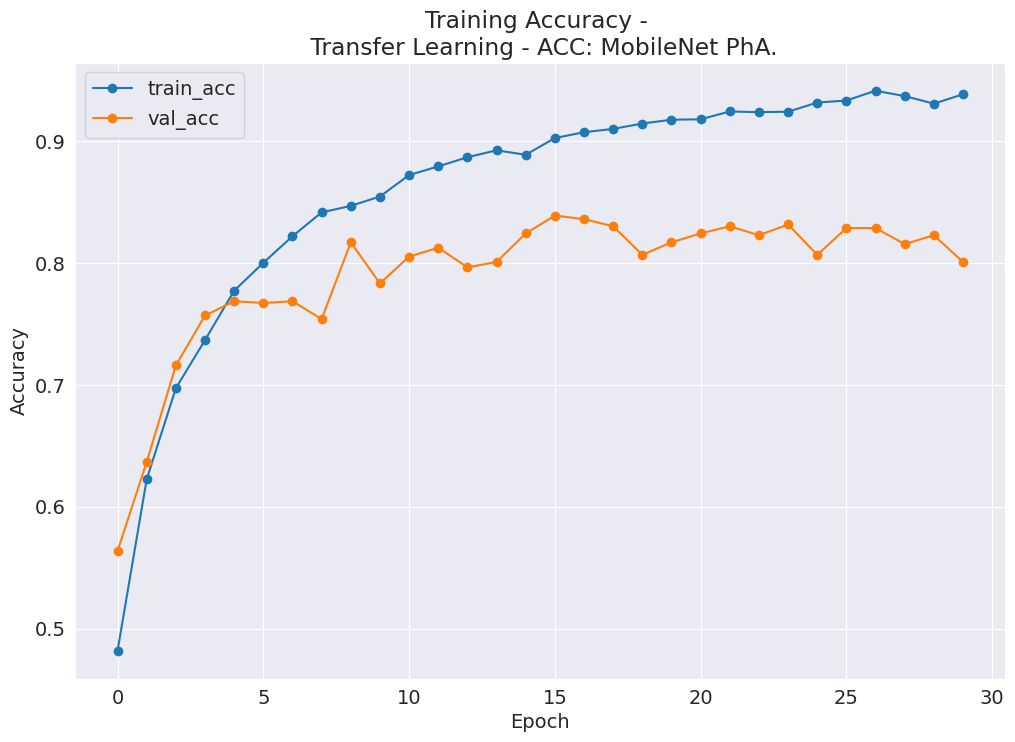

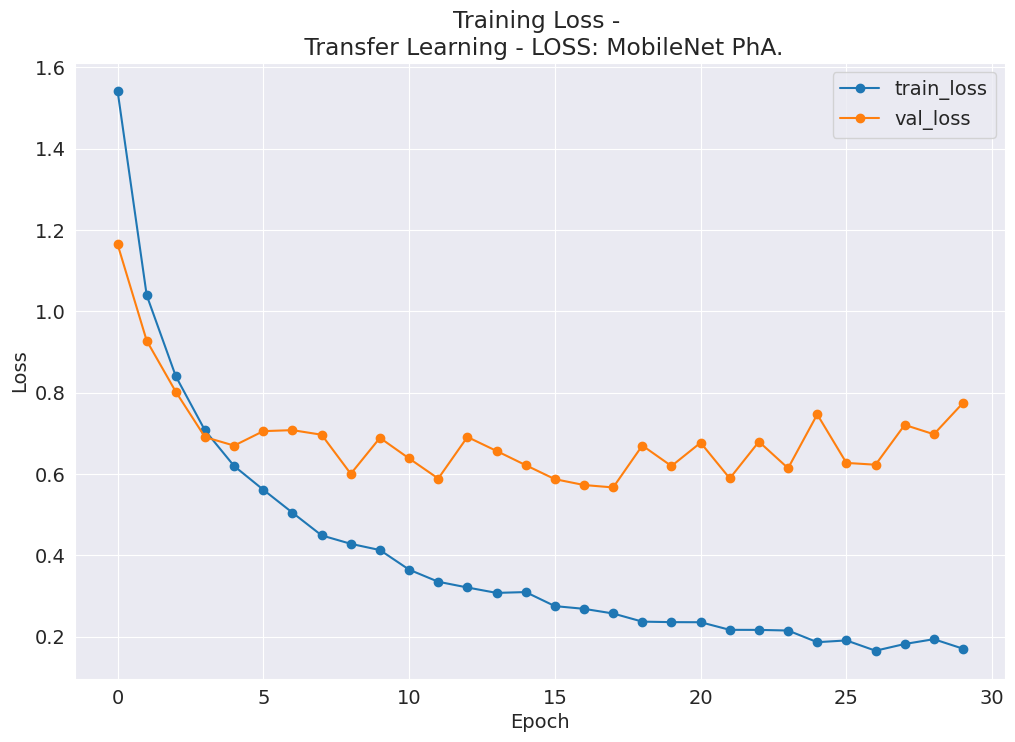

22/22 [==============================] - 1s 26ms/step
Precision: 0.8412005211573678
Recall:    0.8418740849194729
F1:        0.8404988071337652


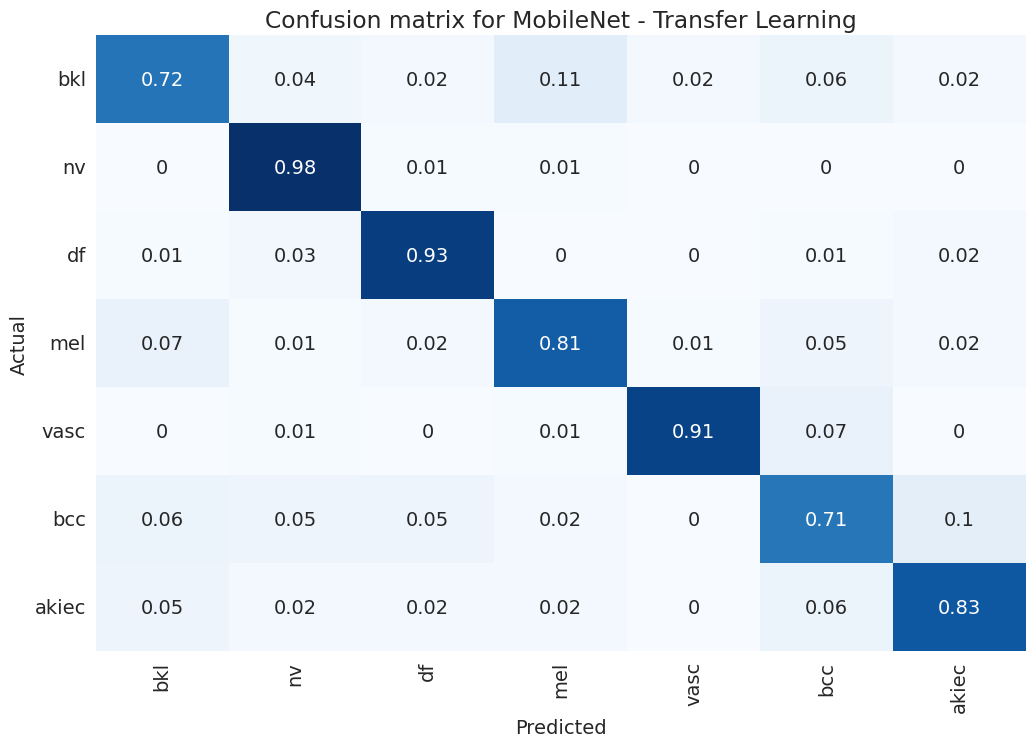

Saved history completed.
Model summary for fine tuning: 
Total params: 3.89M
Trainable params: 3.89M
Non-Trainable params: 0.00M
Epoch 1/60
171/171 [==============================] - ETA: 0s - loss: 3.8911 - accuracy: 0.3203
Epoch 1: val_accuracy did not improve from 0.83895
171/171 [==============================] - 31s 93ms/step - loss: 3.8911 - accuracy: 0.3203 - val_loss: 3.2628 - val_accuracy: 0.3631
Epoch 2/60
171/171 [==============================] - ETA: 0s - loss: 2.0101 - accuracy: 0.5359
Epoch 2: val_accuracy did not improve from 0.83895
171/171 [==============================] - 14s 79ms/step - loss: 2.0101 - accuracy: 0.5359 - val_loss: 1.3361 - val_accuracy: 0.6237
Epoch 3/60
171/171 [==============================] - ETA: 0s - loss: 1.3343 - accuracy: 0.6364
Epoch 3: val_accuracy did not improve from 0.83895
171/171 [==============================] - 14s 79ms/step - loss: 1.3343 - accuracy: 0.6364 - val_loss: 0.8959 - val_accuracy: 0.7306
Epoch 4/60
171/171 [===========

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 1s 28ms/step - loss: 0.1486 - accuracy: 0.9561
Fine Tuning test scores (loss, acc): [0.1485963612794876, 0.9560761451721191]





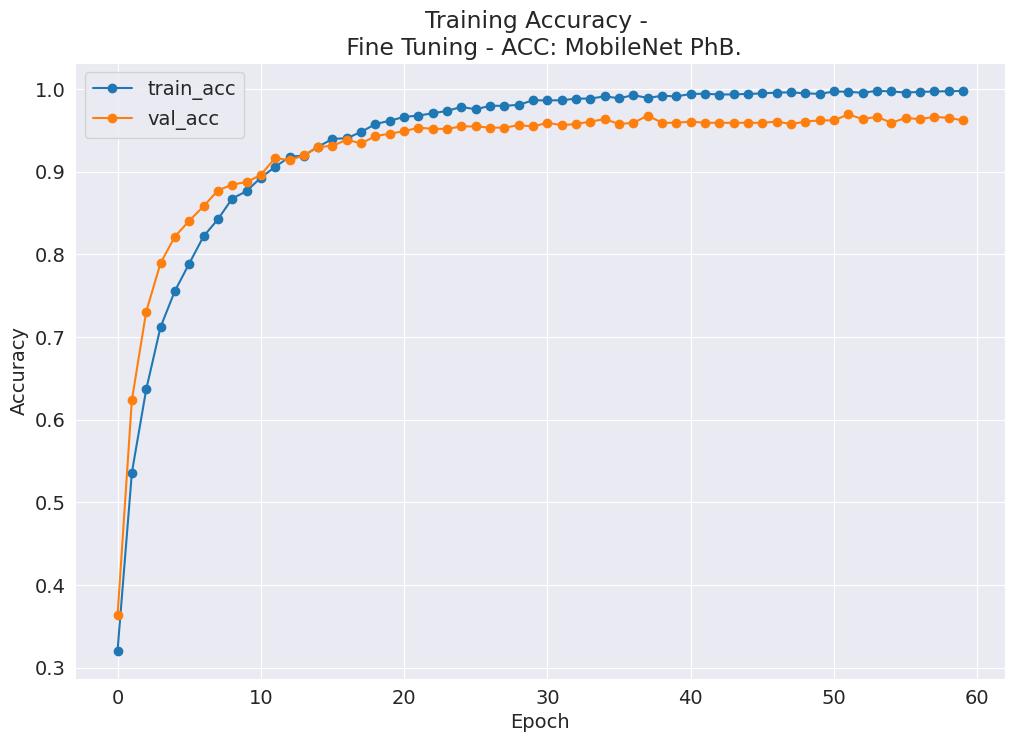

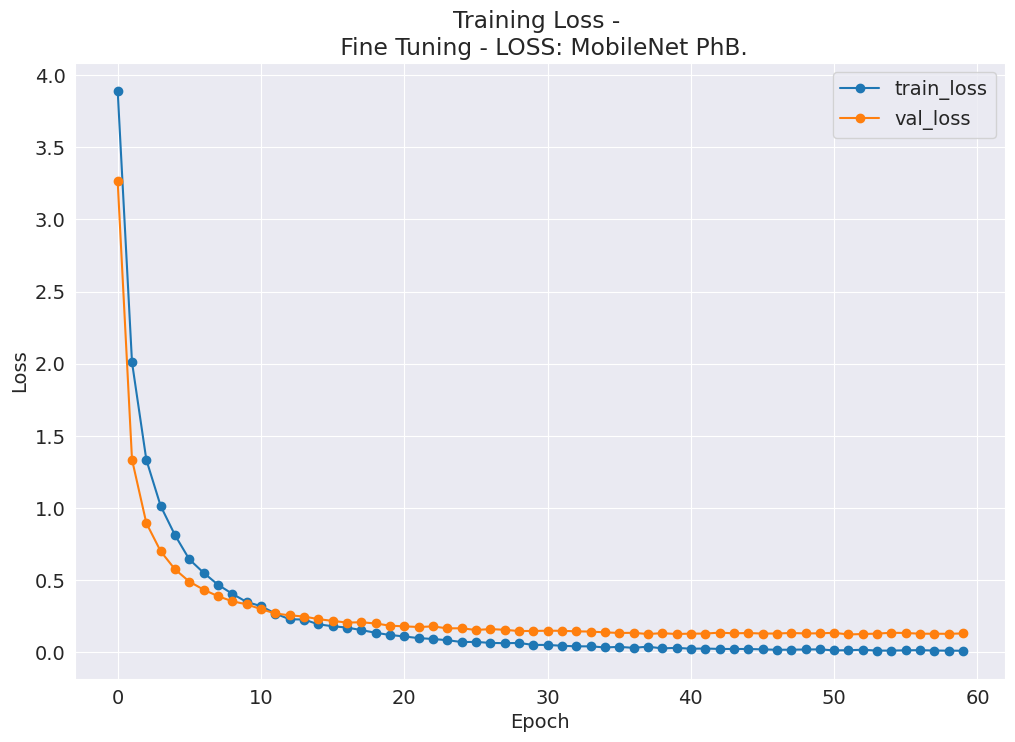

22/22 [==============================] - 1s 25ms/step
Precision: 0.9562943151161731
Recall:    0.9560761346998536
F1:        0.9560937828943311


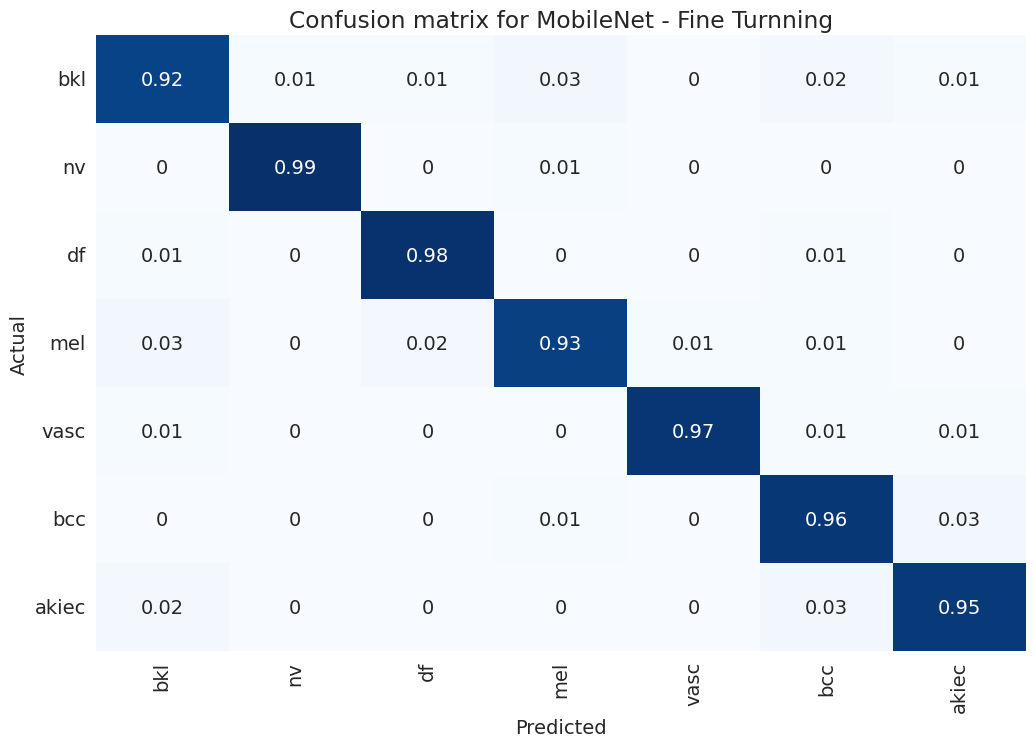

Saved history completed.
Classification Report for MobileNet
              precision    recall  f1-score   support

         bkl       0.93      0.92      0.92        96
          nv       0.99      0.99      0.99        96
          df       0.97      0.98      0.98       100
         mel       0.95      0.93      0.94        96
        vasc       0.99      0.97      0.98        99
         bcc       0.92      0.96      0.94        96
       akiec       0.95      0.95      0.95       100

    accuracy                           0.96       683
   macro avg       0.96      0.96      0.96       683
weighted avg       0.96      0.96      0.96       683



 ==========Completed Process with model MobileNet=========


In [37]:
filtered_models = list(filter(lambda obj: obj.is_ready, sorted(exp_models.values(), key=lambda obj: obj.priority)))
expected_acc = 0.99
for current_model in filtered_models:
    
    best_acc = 0
    print(f'\n\n ==========Start Process with model {current_model.name}=========')
    if current_model.pretrained:
        history, model, best_acc, y_pred = transfer_learning(current_model.model, current_model.name)
        y_true = np.argmax(y_test, axis=1)
        calculate_metrics(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred)
        plot_confusion_matrix(cm, classes, title=f"Confusion matrix for {current_model.name} - Transfer Learning")
        save_history(history.history, f"{current_model.name}-{dataset_name}-transfer-learning-results.csv")
    
    if best_acc < expected_acc:
        history, model, best_acc, y_pred = fine_turning(current_model.model, current_model.name, best_acc)
        y_true = np.argmax(y_test, axis=1)
        calculate_metrics(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred)
        plot_confusion_matrix(cm, classes, title=f"Confusion matrix for {current_model.name} - Fine Turnning")
        save_history(history.history, f"{current_model.name}-{dataset_name}-fine-tuning-results.csv")
    
    print("Classification Report for {}".format(current_model.name))
    print(classification_report(y_true, y_pred, target_names=classes))
    
    print(f'\n\n ==========Completed Process with model {current_model.name}=========')

# Explainable SHAP

In [38]:
import shap

In [39]:
def explain_model(model, arr, label, k=2):
    
    plt.rcParams.update({'font.size': 12})
    # define a masker that is used to mask out partitions of the input image.
    masker = shap.maskers.Image("inpaint_telea", INPUT_SHAPE)
    # create an explainer with model and image masker
    explainer = shap.Explainer(model, masker, output_names=classes)
    
    # here we explain two images using 512 evaluations of the underlying model to estimate the SHAP values
    print('There are predicted results with model explaination:')
    x_indices = np.random.choice(arr.shape[0], size=k, replace=False)
    x_explained = arr[x_indices]
    
    for i in range(k):
        shap_values = explainer(
            x_explained[i:i+1], max_evals=512, batch_size=BATCH_SIZE, outputs=shap.Explanation.argsort.flip[:len(classes)]
        )
        # output with shap values
        shap.image_plot(shap_values, true_labels=[label], labelpad=10)

explain_data = { label: np.stack(items) for label, items in data_dict.items() }
explain_model

<function __main__.explain_model(model, arr, label, k=2)>

Explain model for MobileNet
There are predicted results with model explaination:


  0%|          | 0/510 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:18, 19.00s/it]               


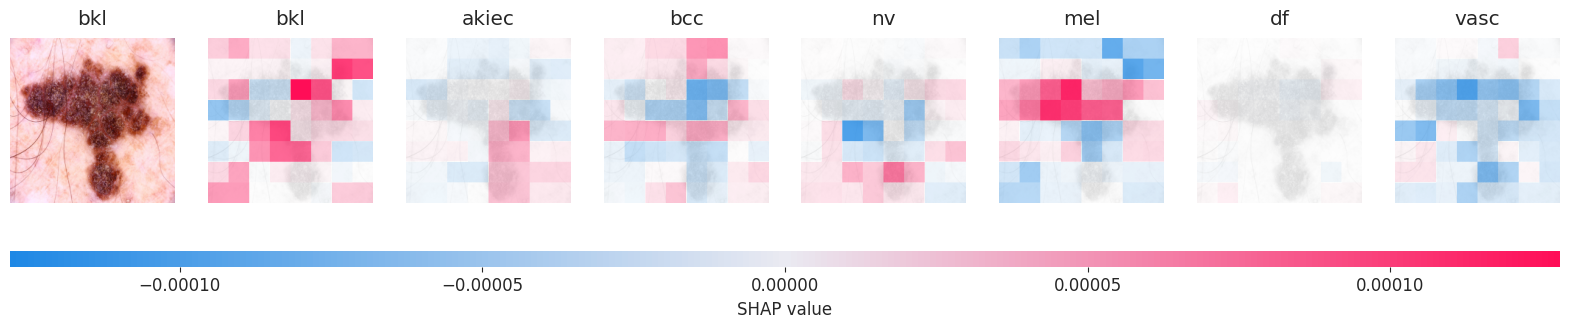

  0%|          | 0/510 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:18, 18.32s/it]               


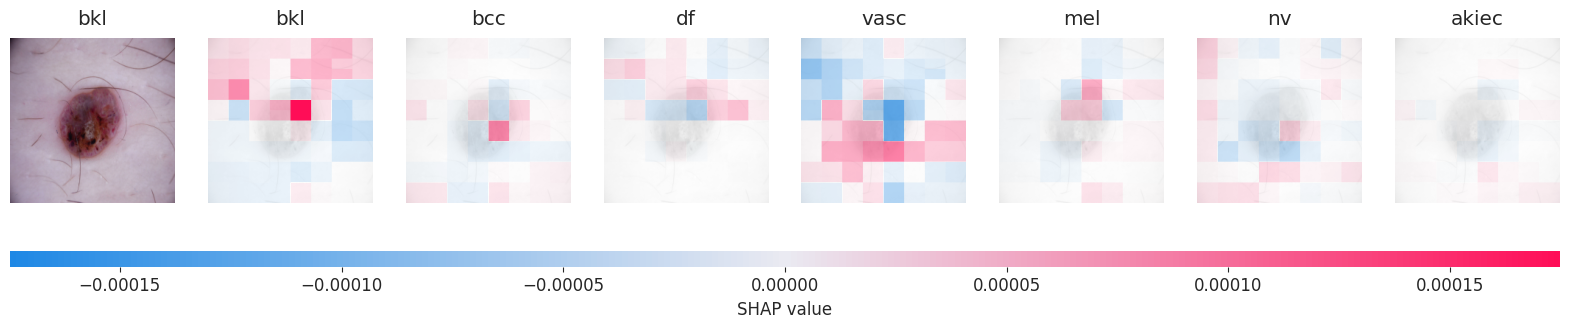

There are predicted results with model explaination:


  0%|          | 0/510 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.56s/it]               


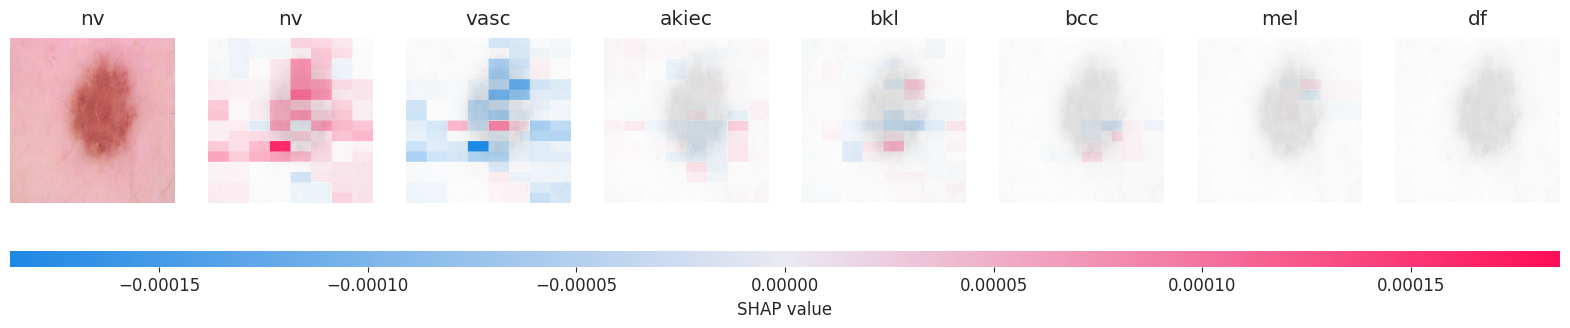

  0%|          | 0/510 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.03s/it]               


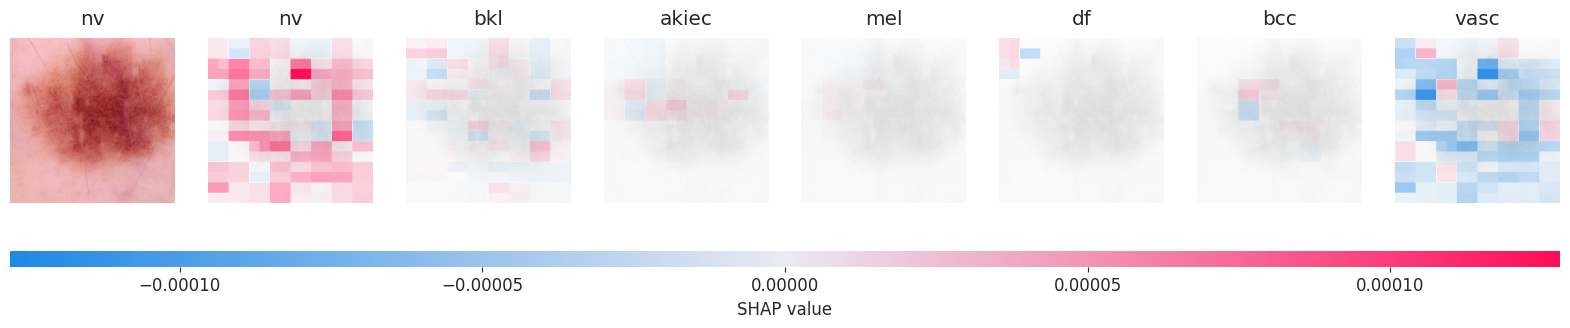

There are predicted results with model explaination:


  0%|          | 0/510 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:15, 15.72s/it]               


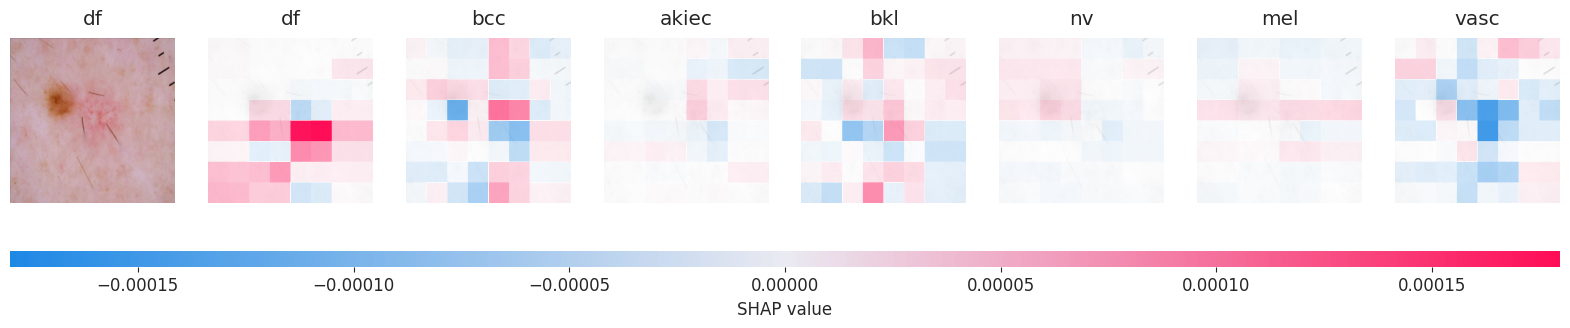

  0%|          | 0/510 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:16, 16.12s/it]               


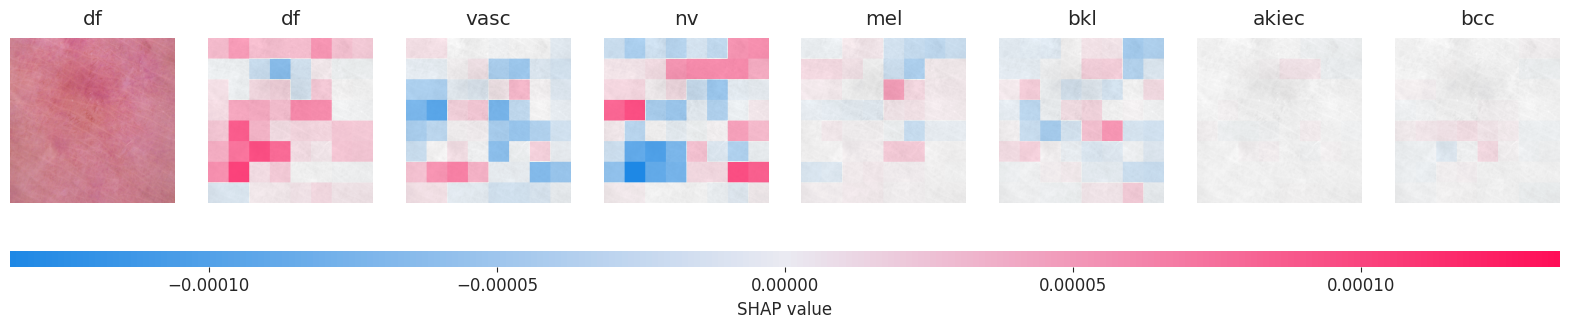

There are predicted results with model explaination:


  0%|          | 0/510 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:16, 16.61s/it]               


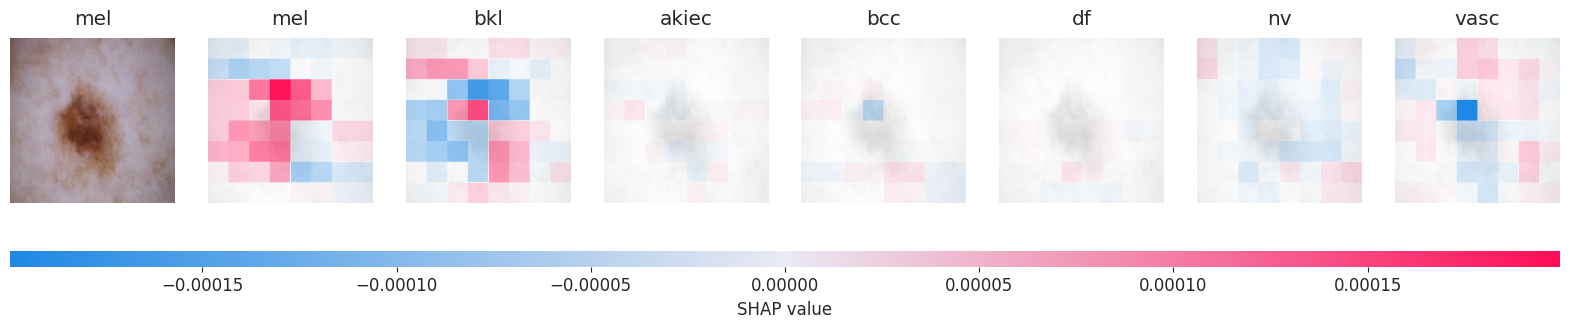

  0%|          | 0/510 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:14, 14.25s/it]               


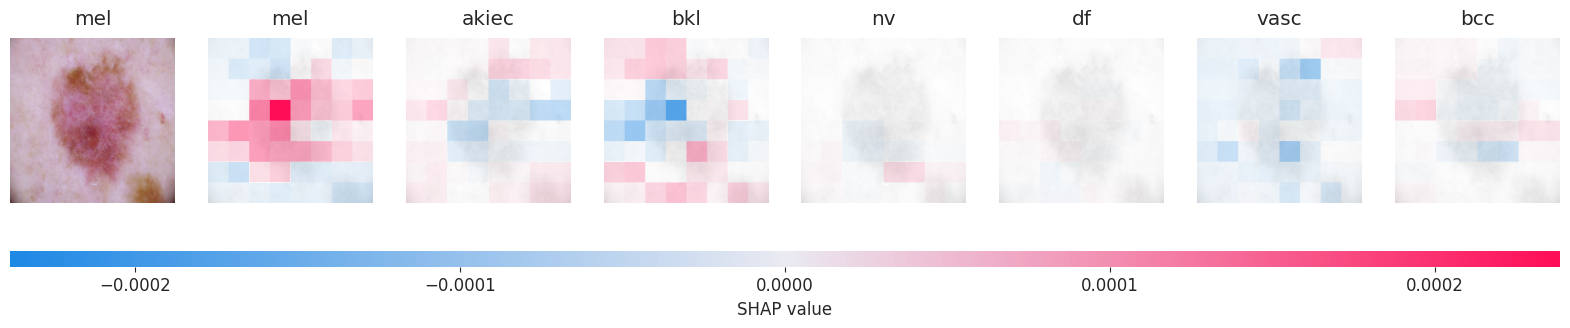

There are predicted results with model explaination:


  0%|          | 0/510 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:14, 14.45s/it]               


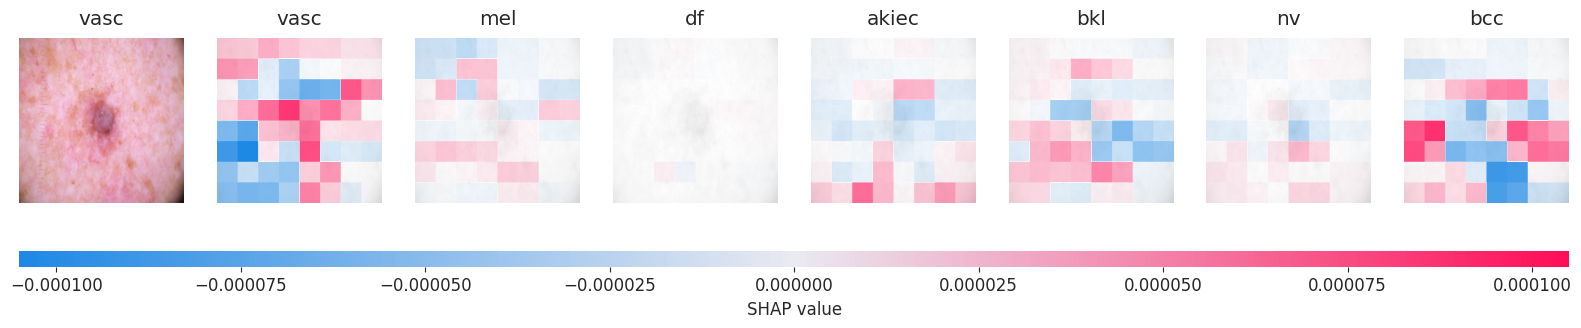

  0%|          | 0/510 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:18, 18.29s/it]               


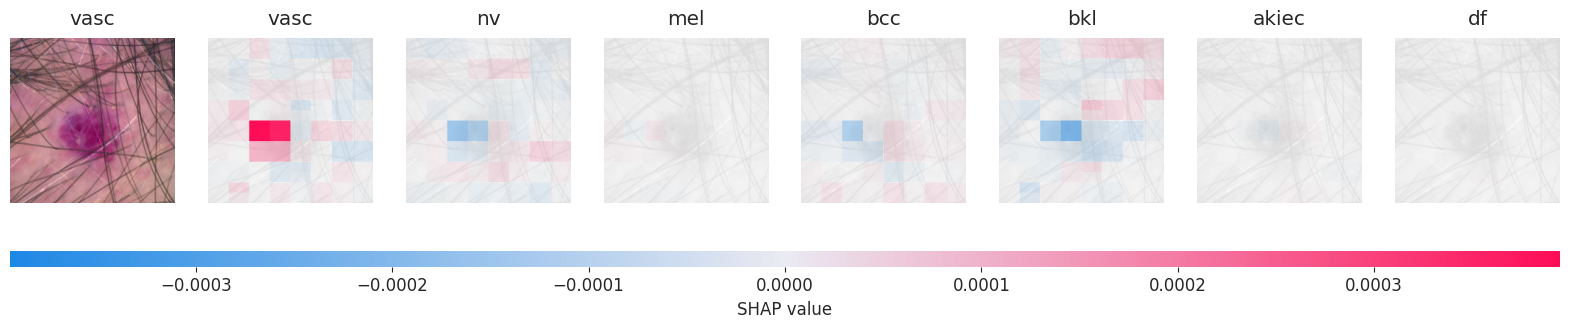

There are predicted results with model explaination:


  0%|          | 0/510 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.31s/it]               


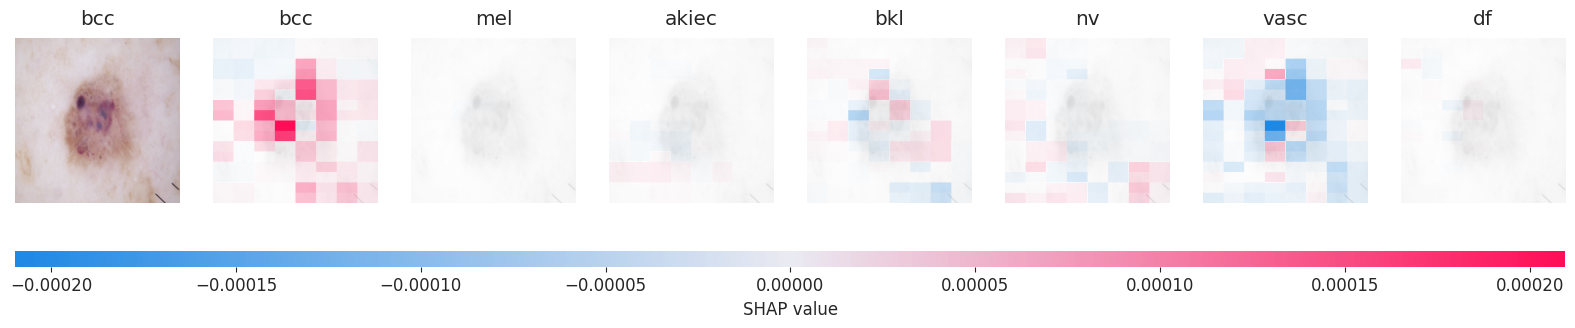

  0%|          | 0/510 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:19, 19.55s/it]               


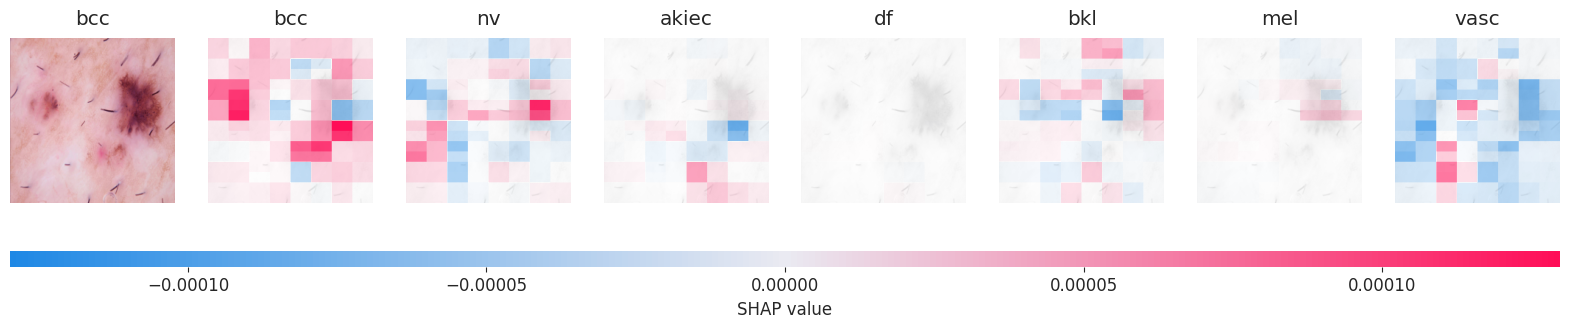

There are predicted results with model explaination:


  0%|          | 0/510 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:16, 16.16s/it]               


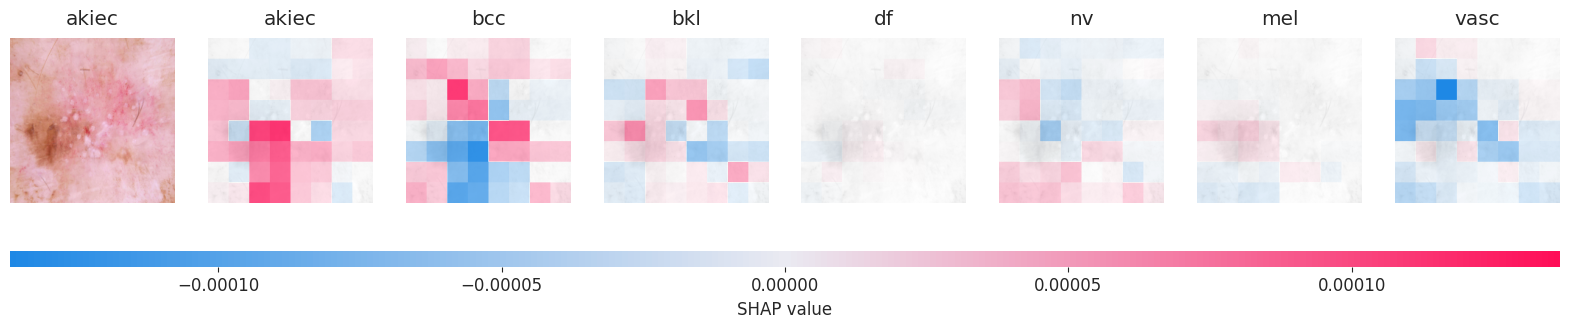

  0%|          | 0/510 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:15, 15.47s/it]               


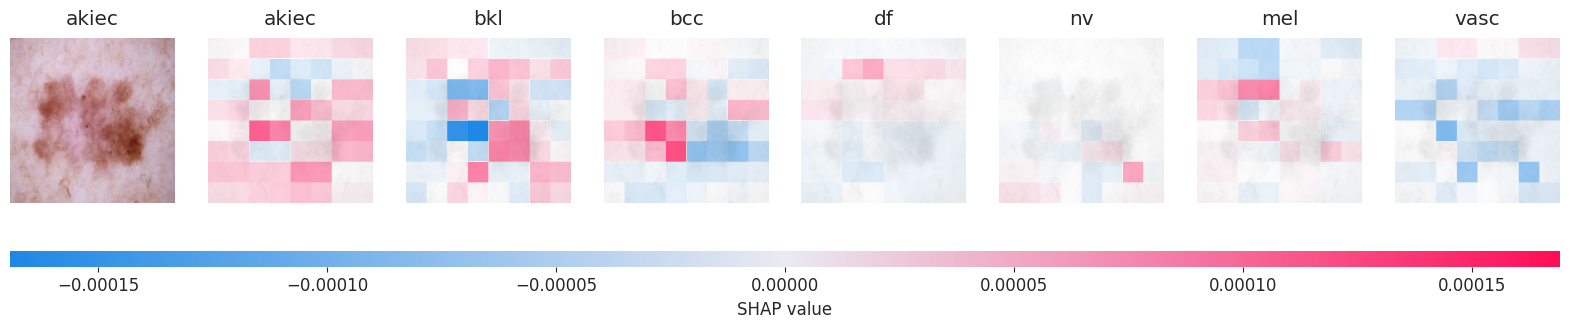

In [40]:
for current_model in filtered_models:
    if not current_model.is_ready: continue
    print(f'Explain model for {current_model.name}')
    for ground_truth, data in explain_data.items():
        explain_model(current_model.model, data, ground_truth, 2)

# Test and Visualize Results

In [41]:
k = 5
n = len(y_test)
sample_idx = np.random.choice(range(n), k)
x_sample = x_test[sample_idx]
y_sample = y_test[sample_idx]
y_sample.shape

(5, 7)



Prediction for MobileNet model
1/1 [==============================] - 0s 352ms/step


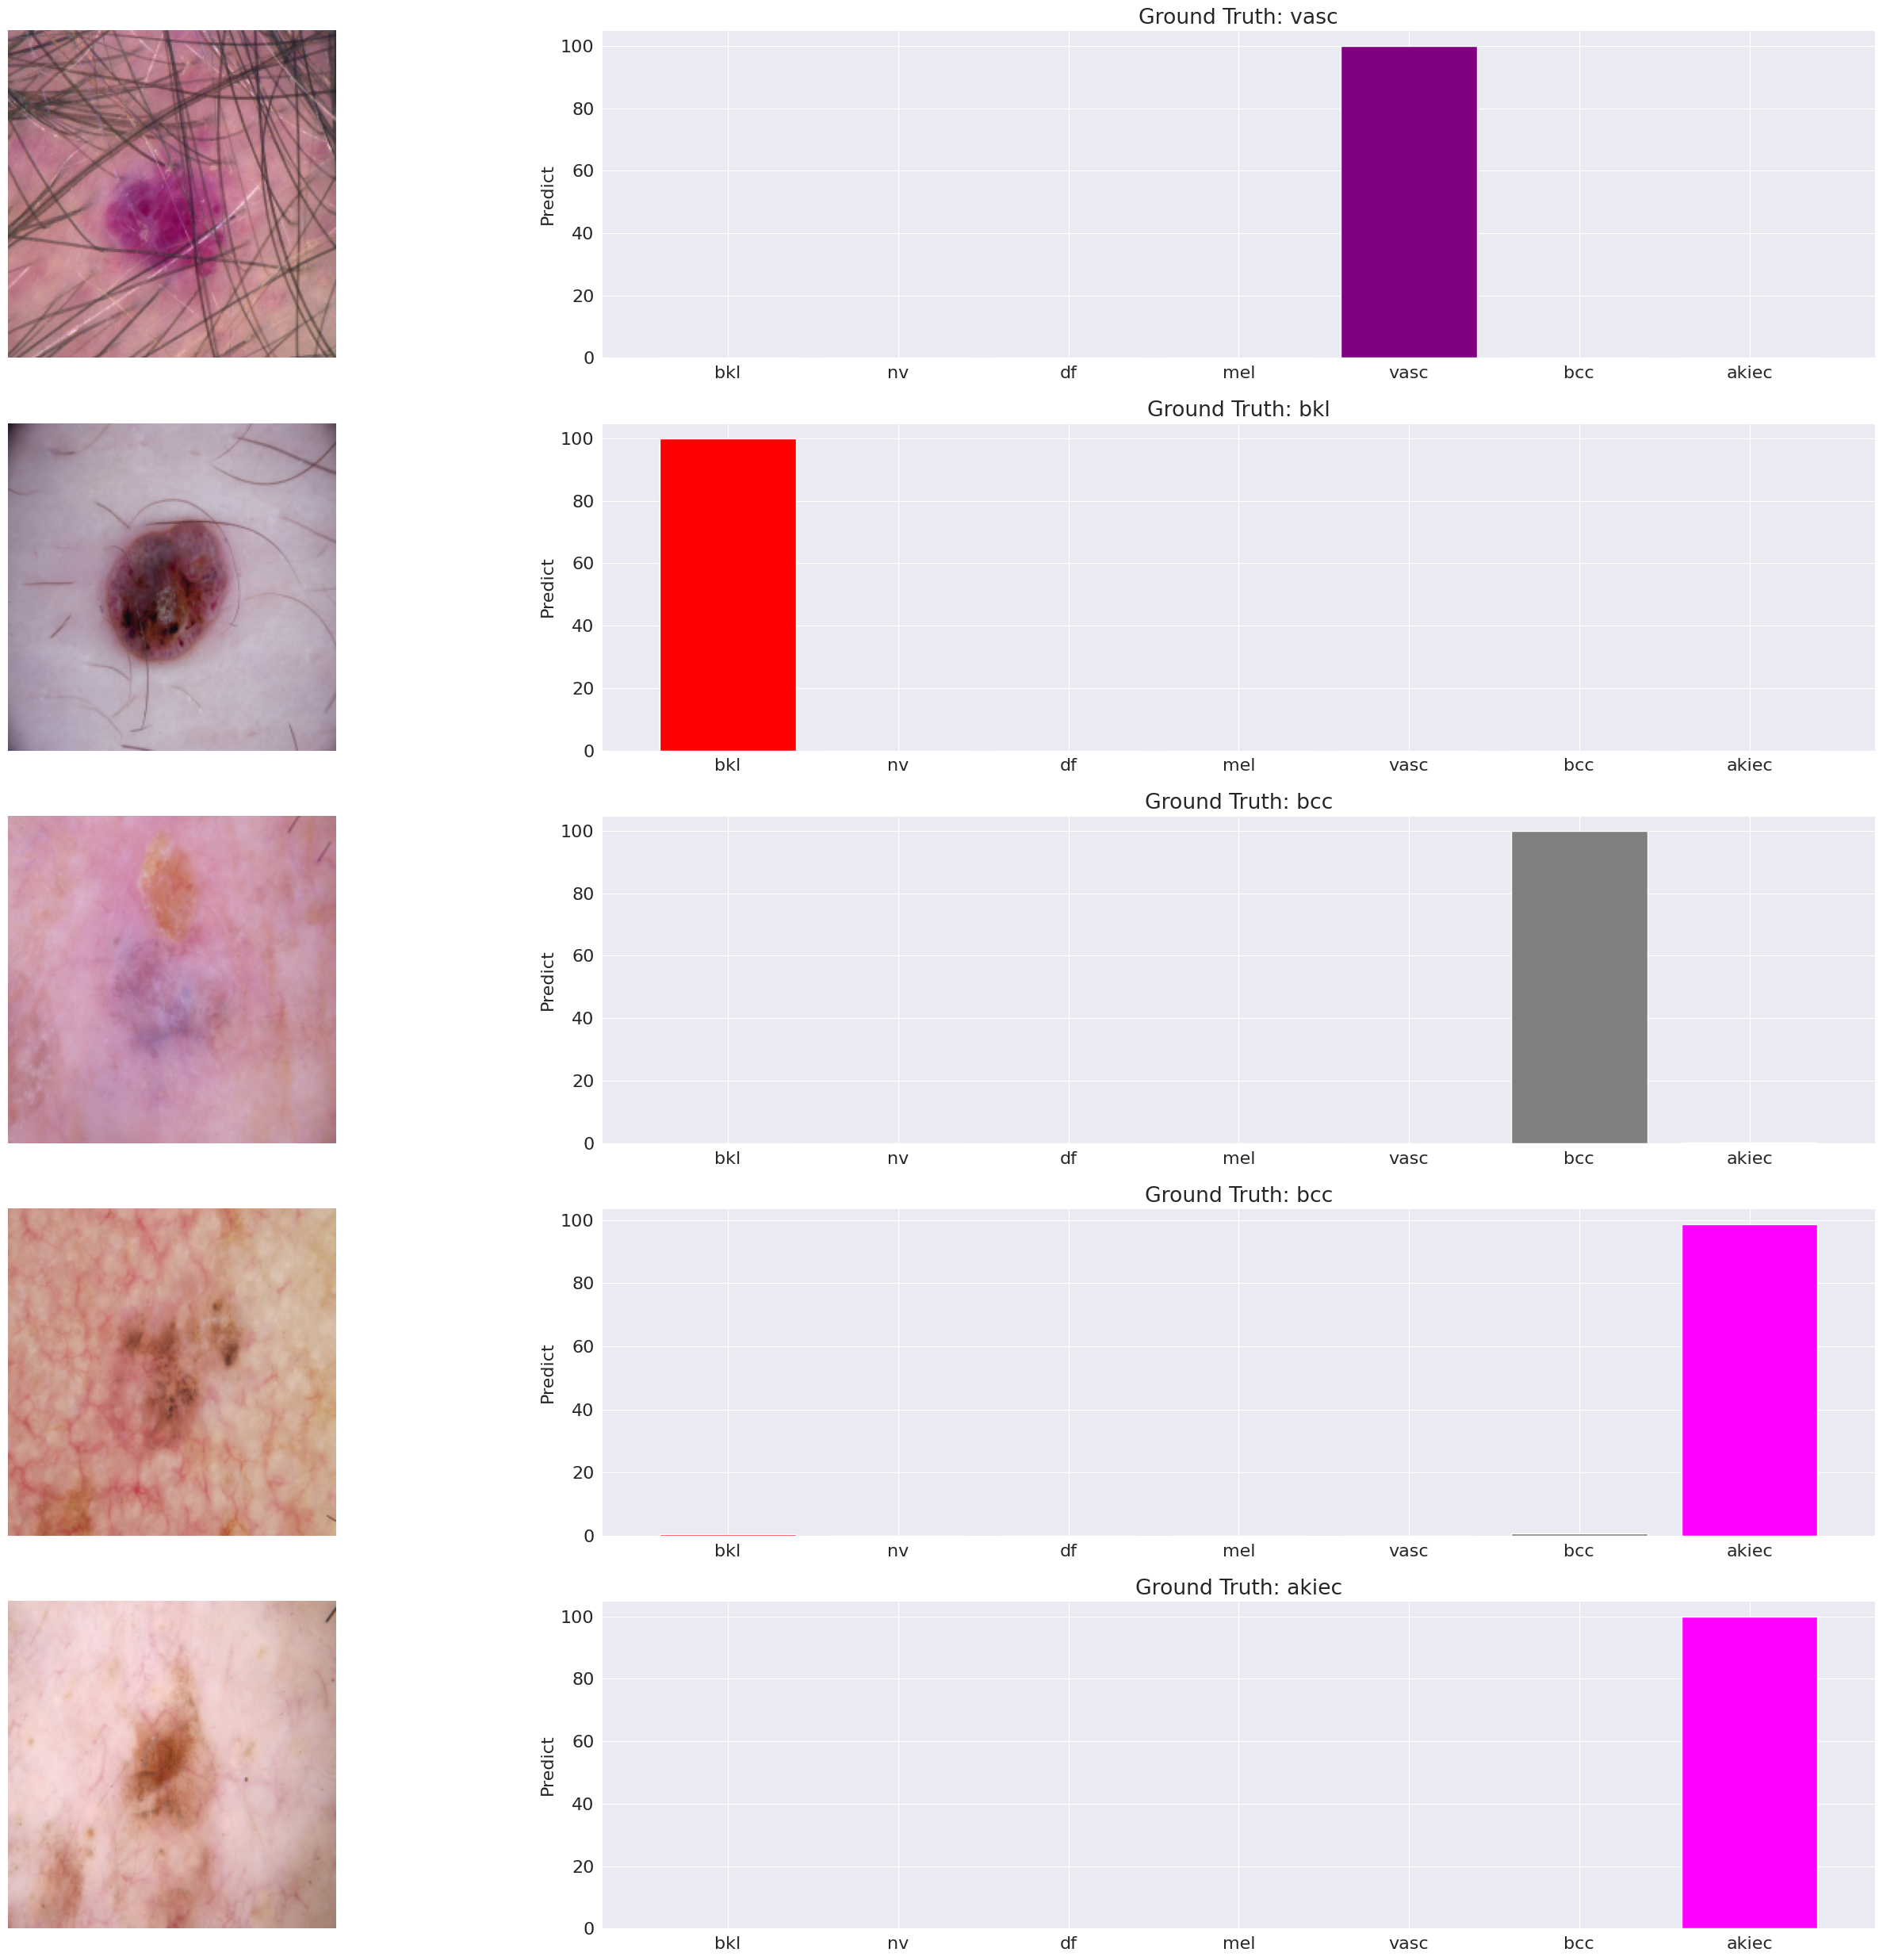

In [42]:
plt.rcParams.update({'font.size': 16})

def format_label(label):
    return '\n'.join(label.split())

short_labels = list(map(format_label, classes))
for current_model in filtered_models:
    if not current_model.is_ready: continue
    model = current_model.model
    print("\n\nPrediction for {} model".format(current_model.name))
    y_pred = model.predict(x_sample)
    fig, ax = plt.subplots(k, 2, figsize=(30, 25))
    y_true = np.argmax(y_sample, axis=1)
    for i in range(k):
        acc = y_pred[i] * 100
        bar_colors = ['red', 'blue', 'green', 'orange', 'purple', 'gray', 'magenta']
        ax[i, 0].imshow(x_sample[i] / 255)
        ax[i, 0].axis('off')
        ax[i, 1].bar(short_labels, acc, label=short_labels, color=[bar_colors[i % len(bar_colors)] for i in range(num_classes)])
        ax[i, 1].set_ylabel('Predict')
        ax[i, 1].set_title('Ground Truth: {}'.format(classes[y_true[i]]))

    plt.tight_layout()
    plt.show()